# <a id='top'>Metal Bands by Country</a>

This project was inspired by a joke I've seen on the comments section of some music videos, usually something along the lines of "you can't walk through a forest in Europe these days without running into a folk metal band" (an example can be found in Sigmarillion's comment [here](https://www.youtube.com/watch?v=TkbadvaMuXo)). I thought I would test that by scraping all the bands from https://www.metal-archives.com/ and combining this data with the % of land area covered by forests to look for any correlation between the number of metal bands per capita and the 'forest density' of each country.

Additionally, with the amount of data scraped, I will likely update this project to include further exploration. 

**Table of Contents**
- [1 Data Scraping](#1)
- [2 Data Preprocessing and exploration](#2)
    - [2.1 Cleaning](#2.1)
    - [2.2 Data exploration](#2.2)
    - [2.3 Aggregate data](#2.3)
    - [2.4 Geographic plots](#2.4)
- [3 Folk metal bands](#3)
    - [3.1 Get bands per capita](#3.1)
    - [3.2 Get forest coverage data](#3.2)
    - [3.3 Linear regression](#3.3)

# 0 Importing libraries and setting constants

In [34]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
# basics
import numpy as np
import pandas as pd
import time
import string
from tabulate import tabulate

# visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# web scraping libraries
import selenium
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

# Geographic libraries
import geopandas
from geopandas import GeoDataFrame

# World bank data library
import wbdata

# Linear regression modeling
from sklearn.linear_model import LinearRegression

# Settings for web-scraping
options = Options()
options.headless = True

alpha = string.ascii_uppercase

# Constants and configuration settings for figures

BIG_FONT = 18
MED_FONT = 15
SMALL_FONT = 12

sns.set_style("darkgrid")
default_color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

# 1 <a id='1'>Scraping data</a>
[back to top](#top)

First, grab data from metal-archives.com. Since this takes about 2 hours to complete, I am leaving this commented out so it's not accidentally run. Until the next update to get additional data (specific location, lyrical themes, label, ect.) we will only open the already-made csv file. 

In [4]:
def scrape_bands(url): 
    """Scrape the data from all sub-pages on metal-archives.
    
    Parameters
    -----------
    url: string
        url of desired page
        ex: passing 'https://www.metal-archives.com/lists/A' will scrape all bands that start with A
    Return
    -----------
    DataFrame: df with band, country, genre, and status
    """
    print(f"getting bands from: {url}")
    
    # Define a sub-function to pull data from the table
    def get_data(browser): 
        elements = browser.find_elements_by_xpath('//*[contains(@id,"bandListAlpha")]//tr')
        data = [[cell.text for cell in row.find_elements_by_xpath(".//*[self::td or self::th]")]
                       for row in browser.find_elements_by_xpath('//*[contains(@id,"bandListAlpha")]//tr')]
        return data
    
    browser = webdriver.Firefox(options=options)
    browser.get(url)
    time.sleep(5)

    data = get_data(browser)
    df = pd.DataFrame(data)

    page_num = 1
    print(f"scrapping page {page_num}")
    
    while True: 
        button = browser.find_element_by_xpath('//*[@id="bandListAlpha_next"]')
        if button.get_attribute("class") == "next paginate_button":

            button.click()
            time.sleep(5)
            page_num += 1
            print(f"scrapping page {page_num}")
            data = get_data(browser)
            df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)
        else: 
            break
    browser.quit()
    
    return df

# pages = alpha + "\#" + "~"

# # Start timer. 
# start = time.time()

# frames = [scrape_bands("https://www.metal-archives.com/lists/" + page) for page in pages]
# bands = pd.concat(frames, ignore_index=True)

# print("done :)")
# end = time.time()
# print(f"time elapsed: {end-start}")
# bands.to_csv("bands_not_cleaned.csv")

bands = pd.read_csv("bands_not_cleaned.csv")
bands.head()

Unnamed: 0                   0              1  \
0           0                Band        Country   
1           1                Band        Country   
2           2       A // Solution  United States   
3           3         A B I S M O         Brazil   
4           4  A Balance of Power  United States   

                               2         3  
0                          Genre    Status  
1                          Genre    Status  
2        Crust Punk/Thrash Metal  Split-up  
3              Doom/Stoner Metal    Active  
4  Melodic Death Metal/Metalcore    Active

# 2 <a id='2'>Data Preprocessing and exploration</a>
[Back to top](#top)

## 2.1 <a id='2.1'>Cleaning</a>
[Back to top](#top)

Rename columns and drop 'Unnamed: 0'

In [5]:
bands = bands.rename(columns={'0': 'Band', '1': 'Country', '2': 'Genre', '3': 'Status'})
bands = bands.drop('Unnamed: 0', 1)
bands.head()

Band        Country                          Genre    Status
0                Band        Country                          Genre    Status
1                Band        Country                          Genre    Status
2       A // Solution  United States        Crust Punk/Thrash Metal  Split-up
3         A B I S M O         Brazil              Doom/Stoner Metal    Active
4  A Balance of Power  United States  Melodic Death Metal/Metalcore    Active

The header rows were included when scraping the data, hence the repeated column names at index 1 and 2. To fix this, drop all records that have "Band" and "Country" as the first two columns

In [6]:
bands = bands.drop(bands[(bands['Band']=='Band') & (bands['Country']=='Country')].index)
bands.head()

Band        Country                          Genre    Status
2       A // Solution  United States        Crust Punk/Thrash Metal  Split-up
3         A B I S M O         Brazil              Doom/Stoner Metal    Active
4  A Balance of Power  United States  Melodic Death Metal/Metalcore    Active
5      A Band of Orcs  United States             Death/Thrash Metal    Active
6   A Baptism by Fire         Canada        Progressive Power Metal    Active

Save the cleaned data

In [7]:
bands.to_csv('bands.csv')

## 2.2<a id='2.2'> Data Exploration</a>
[Back to top](#top)

Now that the dataset is cleaned, let's explore some of its attributes

In [8]:
bands.describe()

Band        Country        Genre  Status
count    168308         168308       168308  168308
unique   118966            153         9586       6
top     Abaddon  United States  Black Metal  Active
freq        102          35851        21223   93823

In [9]:
bands.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168308 entries, 2 to 169003
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Band     168308 non-null  object
 1   Country  168308 non-null  object
 2   Genre    168308 non-null  object
 3   Status   168308 non-null  object
dtypes: object(4)
memory usage: 6.4+ MB


**Summary:**
- There are no nulls
- The most popular band name appears to be 'Abaddon'
- Most metal bands are from the United States
- The most popular Genre is Black Metal

How many genres are listed? 

In [10]:
bands['Genre'].value_counts()

Black Metal                                            21223
Death Metal                                            13669
Heavy Metal                                            10898
Thrash Metal                                           10841
Melodic Death Metal                                     4398
                                                       ...  
Groove Metal/Metalcore with Thrash Metal influences        1
Ambient/Black Metal (early); Gothic Metal (later)          1
Atmospheric/Black Metal                                    1
Black Metal/Noise/Depressive Rock                          1
Power A Cappella                                           1
Name: Genre, Length: 9586, dtype: int64

There are over 9,000 different genres found- although it looks like this is because many bands can be classified as multiple genres. 

How are statuses distributed? 

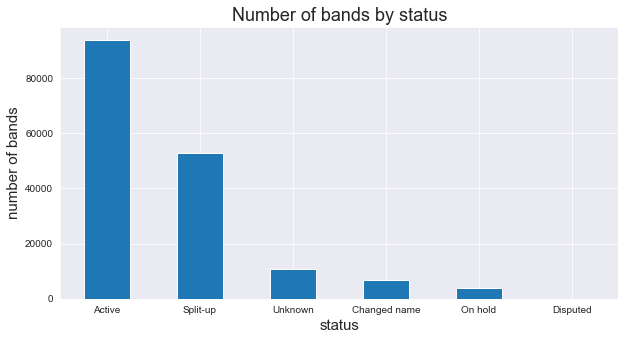

In [11]:
fig, ax = plt.subplots(figsize=[10, 5])
bands['Status'].value_counts().plot.bar()
ax.set_title("Number of bands by status", fontsize=BIG_FONT)
ax.set_xlabel("status", fontsize=MED_FONT)
ax.set_ylabel("number of bands", fontsize=MED_FONT);
plt.xticks(rotation=0);

Most of the bands presented are active, while approximately 1/3 are split-up.

## 2.3 <a id='2.3'>Aggregate Data</a>
[Back to top](#top)

Next, we are interested in the number of bands per country, so aggregate the data accordingly

In [12]:
def agg_bands(df=bands, genre_filter=None): 
    """Aggregate data to number of bands per country, with the option of counting bands with a specified genre."""
    if genre_filter is not None: 
        df = df[df['Genre'].str.contains(genre_filter)]

    bands_df = pd.DataFrame({"Country": df['Country'].unique(), 
                         "num_bands": [len(df[df['Country'] == country]) 
                                       for country in df['Country'].unique()]
                        }).sort_values(by="num_bands", ascending=False)
    bands_df['num_bands'] = bands_df['num_bands'].fillna(0)
    return bands_df

In [13]:
num_bands = agg_bands(bands)
num_bands.head()

Country  num_bands
0   United States      35851
4         Germany      13586
9           Italy       8261
1          Brazil       7958
3  United Kingdom       6764

Plot the number of metal bands per country, only including the top 15.

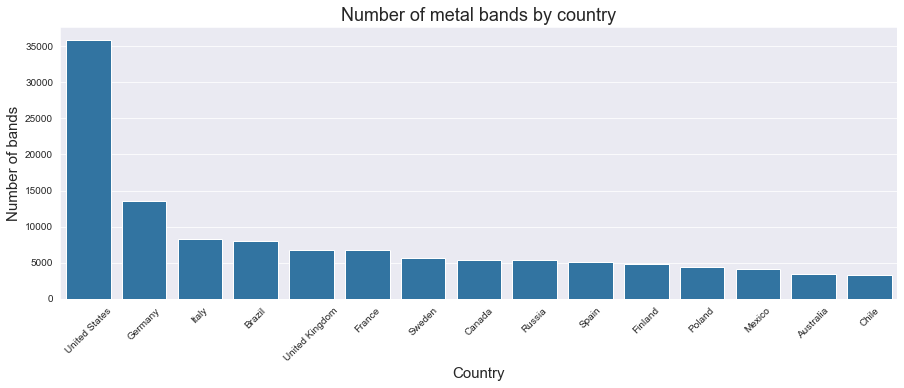

In [14]:
fig, ax = plt.subplots(figsize=[15, 5])
sns.barplot(x=num_bands['Country'].values[:15], y=num_bands['num_bands'].values[:15], color=default_color)
ax.set_title("Number of metal bands by country", fontsize=BIG_FONT)
ax.set_ylabel("Number of bands", fontsize=MED_FONT)
ax.set_xlabel("Country", fontsize=MED_FONT)
plt.xticks(rotation=45);

## 2.4 <a id='2.4'>Geographic plots</a>
[Back to top](#top)

Set up geopandas and make geographic plots. Use the default 'world' dataset that comes with geopandas for country shapes.

In [15]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

Merge the bands dataset with this default dataset to make a geographic plot of the number of metal bands in each country.

In [16]:
bands_plot = GeoDataFrame(num_bands.merge(world, 
                                         how="outer", 
                                         left_on="Country", 
                                         right_on="name").drop(["continent", "gdp_md_est"], 1)
                         )
bands_plot.head()

Country  num_bands      pop_est            name iso_a3  \
0   United States    35851.0          NaN             NaN    NaN   
1         Germany    13586.0   80594017.0         Germany    DEU   
2           Italy     8261.0   62137802.0           Italy    ITA   
3          Brazil     7958.0  207353391.0          Brazil    BRA   
4  United Kingdom     6764.0   64769452.0  United Kingdom    GBR   

                                            geometry  
0                                               None  
1  POLYGON ((14.11969 53.75703, 14.35332 53.24817...  
2  MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...  
3  POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...  
4  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...

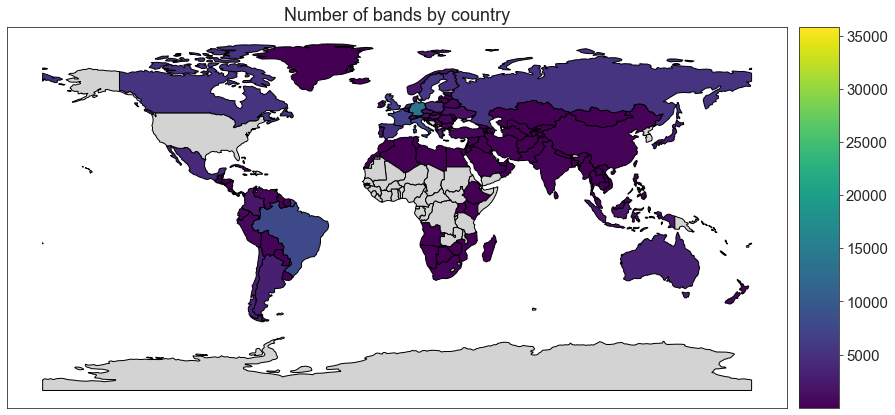

In [17]:
def plot_map(df_plot, col_plot='num_bands', title="Number of bands by country", figsize=[15, 15]): 
    df_plot = GeoDataFrame(df_plot)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=figsize)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        h = df_plot.plot(column=col_plot, 
                            ax=ax, 
                            legend=True, 
                            cax=cax, 
                            cmap="viridis", 
                            edgecolor='black', 
                            missing_kwds={'color': 'lightgrey'}
                        )
        cb_ax=fig.axes[1] 
        cb_ax.tick_params(labelsize=MED_FONT)
        h.set(xticklabels=[])
        h.set(yticklabels=[])
        ax.set_title(title, fontsize=BIG_FONT)
plot_map(bands_plot)

It appears we are missing some data!

As plotted above, the United States should be bright yellow.The most likely scenario is that there is a discrepancy between countries in the 'bands' dataset and countries in 'world'

In [18]:
diffs = [elem for elem in num_bands['Country'] if elem not in world['name'].values]
print(f"Countries listed in 'bands' that are not in 'world':\n\n{diffs}")

Countries listed in 'bands' that are not in 'world':

['United States', 'International', 'Singapore', 'Korea, South', 'Unknown', 'Bosnia and Herzegovina', 'North Macedonia', 'Malta', 'Dominican Republic', 'Hong Kong', 'Faroe Islands', 'Reunion', 'Liechtenstein', 'Bahrain', 'Guernsey', 'Maldives', 'Åland Islands', 'San Marino', 'Gibraltar', 'Isle of Man', 'Jersey', 'Andorra', 'Guam', 'Monaco', 'Mauritius', 'Barbados', 'French Polynesia', 'Aruba', 'Saint Pierre and Miquelon', 'Svalbard', 'Curaçao', 'East Timor']


The bands dataset contains independent city-states, micro-countries, and words some countries differently (e.g. 'United States' instead of 'United States of America'). Rename these countries to either have the same name in the world dataset or use a nearby country. 

In [19]:
world_countries = world['name'].unique()
world_countries.sort()
world_countries

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herz.', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Central African Rep.', 'Chad', 'Chile',
       'China', 'Colombia', 'Congo', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czechia', "Côte d'Ivoire", 'Dem. Rep. Congo', 'Denmark',
       'Djibouti', 'Dominican Rep.', 'Ecuador', 'Egypt', 'El Salvador',
       'Eq. Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Is.',
       'Fiji', 'Finland', 'Fr. S. Antarctic Lands', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran',
       'Iraq', 

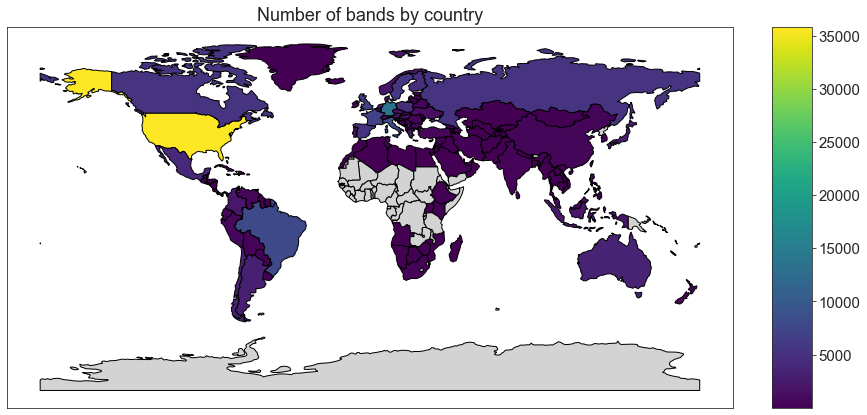

In [20]:
def merge_band_world(band_df, world_df, genre_filter=None): 

    diffs_dict = {
        "United States"             : "United States of America", 
        "Korea, South"              : "South Korea",
        "Bosnia and Herzegovina"    : "Bosnia and Herz.",
        "North Macedonia"           : "Macedonia", 
        "Malta"                     : "Italy",
        "Dominican Republic"        : "Dominican Rep.", 
        "Hong Kong"                 : "China", 
        "Faroe Islands"             : "Denmark",
        "Reunion"                   : "France", 
        "Liechtenstein"             : "Germany", 
        "Bahrain"                   : "Saudi Arabia", 
        "Guernsey"                  : "United Kingdom", 
        "Maldives"                  : "India", 
        "Åland Islands"             : "Finland", 
        "San Marino"                : "Italy", 
        "Gibraltar"                 : "United Kingdom",
        "Isle of Man"               : "United Kingdom",
        "Jersey"                    : "United Kingdom",
        "Andorra"                   : "Spain", 
        "Guam"                      : "United States of America", 
        "Monaco"                    : "France", 
        "Mauritius"                 : "Madagascar", 
        "Barbados"                  : "United Kingdom",
        "French Polynesia"          : "France",
        "Aruba"                     : "Netherlands", 
        "Saint Pierre and Miquelon" : "France",
        "Svalbard"                  : "Norway", 
        "Curaçao"                   : "Denmark",
        "East Timor"                : "Timor-Leste"
    }
    band_df = band_df.replace(to_replace=diffs_dict)
    band_df = band_df.drop(band_df[band_df['Country'].isin(["Unknown", "International"])].index)

    num_bands = agg_bands(band_df, genre_filter=genre_filter)
    bands = GeoDataFrame(num_bands.merge(world, 
                                              how="outer", 
                                              left_on="Country", 
                                              right_on="name").drop(["gdp_md_est"], 1)
                             )
    
    bands['bands per capita'] = bands.num_bands / (bands.pop_est / 1e5)
    

    return bands

bands_plot = merge_band_world(bands, world)
plot_map(bands_plot)

Next, control for population by plotting bands per capita.

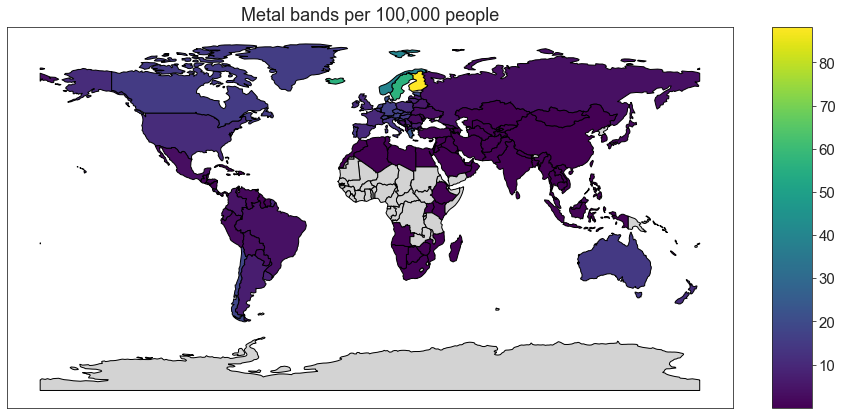

In [21]:
plot_map(bands_plot, col_plot="bands per capita", title="Metal bands per 100,000 people")

# 3 <a id='3'>Folk Metal Bands</a> 
[Back to top](#top)

## 3.1 <a id='3.1'>Get Bands Per Capita</a>
[Back to top](#top)

Now, do a similar analysis with folk metal bands only

Check which genres contain the word "Folk"

In [22]:
bands['Genre'][bands['Genre'].str.contains('Folk')].value_counts()

Folk Metal                                                              420
Folk/Black Metal                                                        152
Black/Folk Metal                                                        141
Pagan/Folk Metal                                                         76
Melodic Death/Folk Metal                                                 55
                                                                       ... 
Folk Rock (early), Experimental/Progressive Death/Doom Metal (later)      1
Epic Progressive/Folk Metal                                               1
Symphonic Death/Folk Metal                                                1
Drone/Doom Metal with Folk influences                                     1
Melodic Death Metal with Folk Metal influences                            1
Name: Genre, Length: 657, dtype: int64

Notice that "Folk Metal" doesn't always appear as is, so we will filter to include any band that has the word "Folk" in the genre

In [23]:
num_folk_metal_bands = agg_bands(bands, genre_filter="Folk")
num_folk_metal_bands.sort_values(by="num_bands", ascending=False).head(10)

Country  num_bands
3           Russia        215
11   United States        209
14         Germany        196
0            Italy        163
19           Spain        103
4   United Kingdom         99
9           France         98
10         Finland         92
15          Canada         90
36          Sweden         85

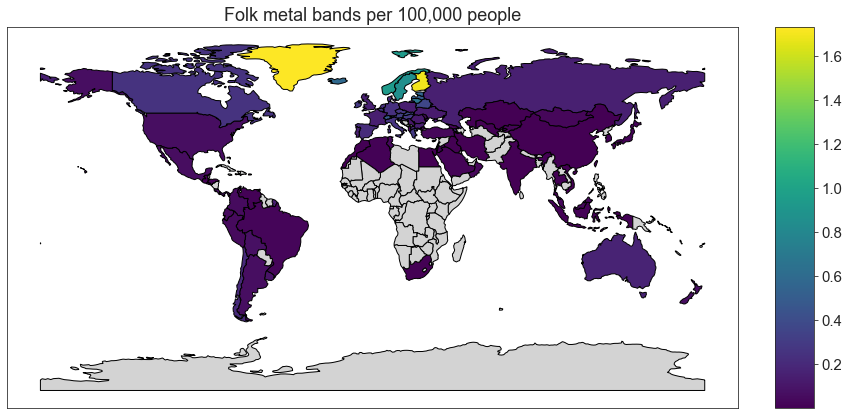

In [24]:
plot_map(merge_band_world(bands, world, genre_filter="Folk"), 
         col_plot="bands per capita", 
         title="Folk metal bands per 100,000 people")

In [25]:
bands_plot.sort_values(by="bands per capita", ascending=False).head()

Country  num_bands     pop_est continent     name iso_a3  \
10  Finland     4849.0   5491218.0    Europe  Finland    FIN   
6    Sweden     5655.0   9960487.0    Europe   Sweden    SWE   
60  Iceland      192.0    339747.0    Europe  Iceland    ISL   
21   Norway     2121.0   5320045.0    Europe   Norway    -99   
18   Greece     2526.0  10768477.0    Europe   Greece    GRC   

                                             geometry  bands per capita  
10  POLYGON ((28.59193 69.06478, 28.44594 68.36461...         88.304635  
6   POLYGON ((11.02737 58.85615, 11.46827 59.43239...         56.774332  
60  POLYGON ((-14.50870 66.45589, -14.73964 65.808...         56.512640  
21  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...         39.868084  
18  MULTIPOLYGON (((26.29000 35.29999, 26.16500 35...         23.457356

Evidently, Greenland has the highest number of folk metal bands per capita. However, this should be considered an outlier since there is only one band and it has a very small population. 

Other than that, it would come as no surprise that Finland, Norway, and Sweden have the most folk metal bands per capita. 

## 3.2 <a id='3.2'>Get forest coverage data</a>
[Back to top](#top)

Import and clean the forset data from the world bank using the wbdata package. 

In [26]:
forest_data = pd.DataFrame(wbdata.get_dataframe({'AG.LND.FRST.ZS': 'percent forest coverage'}, convert_date=True))
forest_data.head()

percent forest coverage
country    date                               
Arab World 2020-01-01                      NaN
           2019-01-01                      NaN
           2018-01-01                      NaN
           2017-01-01                      NaN
           2016-01-01                 1.682361

Select only data from 2016 and do some re-indexing.

In [27]:
forest_data = forest_data[forest_data.index.get_level_values(level=1) == pd.to_datetime("2016-01-01")].droplevel(1)
forest_data.head()

percent forest coverage
country                                                
Arab World                                     1.682361
Caribbean small states                        85.033445
Central Europe and the Baltics                34.251720
Early-demographic dividend                    21.850907
East Asia & Pacific                           26.359846

In [28]:
forest_data['country'] = forest_data.index
forest_data.index = range(len(forest_data))
cols = forest_data.columns.tolist()
cols = cols[::-1]
forest_data = forest_data[cols]
forest_data.head()

country  percent forest coverage
0                      Arab World                 1.682361
1          Caribbean small states                85.033445
2  Central Europe and the Baltics                34.251720
3      Early-demographic dividend                21.850907
4             East Asia & Pacific                26.359846

Finally, merge the band (filtering to only include bands with genres that have the word "Folk"), world, and forest data together. 

In [29]:
folk_metal_bands = merge_band_world(bands, world, genre_filter="Folk")
band_data = forest_data.merge(folk_metal_bands, how="outer", left_on="country", 
                      right_on="name")
band_data = band_data.drop(band_data[band_data['name'].isna()].index)
band_data = band_data[["name", "continent", "bands per capita", "pop_est", "percent forest coverage", "geometry"]]
band_data = band_data.rename(columns={'name': 'Country'})
band_data = band_data.fillna(0)
band_data.head()

Country      continent  bands per capita     pop_est  \
47  Afghanistan           Asia          0.000000  34124811.0   
48      Albania         Europe          0.032809   3047987.0   
49      Algeria         Africa          0.009763  40969443.0   
52       Angola         Africa          0.000000  29310273.0   
54    Argentina  South America          0.065473  44293293.0   

    percent forest coverage                                           geometry  
47                 2.067825  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
48                28.121897  POLYGON ((21.02004 40.84273, 20.99999 40.58000...  
49                 0.824439  POLYGON ((-8.68440 27.39574, -8.66512 27.58948...  
52                46.307210  MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...  
54                 9.798406  MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...

## 3.3 <a id='3.3'>Linear Regression</a>
[Back to top](#top)

Finally, use simple linear regression to look for correlations between % forest coverage and number of folk metal bands per capita. 

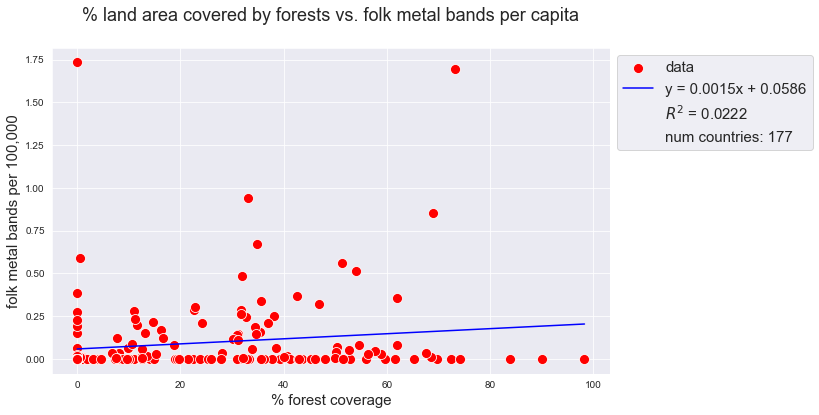

In [30]:
def calc_regression(band_data, plot=True, title=None, save=False, savename="metal.png"): 
    """ """
    # Split the data into dependent and independent variables
    X = band_data["percent forest coverage"].values.reshape(-1, 1)
    y = band_data["bands per capita"].values.reshape(-1, 1)

    if len(X) < 5: 
        raise ValueError("not enough datapoints")
    # Split into the training set and test set. 
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Train the model. 
    regressor = LinearRegression()
    regressor.fit(X, y)

    # Get parameters.
    r_square = round(regressor.score(X, y), 4)
    r_label = f"$R^2$ = {r_square}"
    num_bands = f"num countries: {len(X)}"
    
    b = round(regressor.intercept_[0], 4)
    m = round(regressor.coef_[0][0], 4)

    # Make and format plot.
    if plot: 
        fig, ax = plt.subplots(figsize=[10, 6])
        
        # Draw the data. 
        sns.scatterplot(x=band_data["percent forest coverage"].values, 
                        y=band_data["bands per capita"].values, 
                        ax=ax, 
                        s=100, 
                        color='r', 
                        label='data')
        
        # Draw line of best fit. 
        fit_label = f"y = {m}x + {b}"
        sns.lineplot(x=X.reshape(1,-1)[0], y=regressor.predict(X).reshape(1,-1)[0], color='b', label=fit_label)

        # Format legend
        plt.plot([], [], ' ', label=r_label)
        plt.plot([], [], ' ', label=num_bands)
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [3, 0, 1, 2]

        plt.legend([handles[idx] for idx in order],
                   [labels[idx] for idx in order], 
                   bbox_to_anchor=(1,1),  
                   loc='upper left',
                   fontsize=MED_FONT
                  )
        
        # Label title / axes
        if title is None:
            title = "% land area covered by forests vs. folk metal bands per capita\n"
        ax.set_title(title, fontsize=BIG_FONT)
        ax.set_ylabel("folk metal bands per 100,000", fontsize=MED_FONT)
        ax.set_xlabel("% forest coverage", fontsize=MED_FONT)

        if save: 
            plt.savefig(savename)
        plt.show()
        
    return m, b, r_square, len(X)

calc_regression(band_data);

It would appear that worldwide, this relationship is not very strong. Let's try breaking this down by continent to see if a relationship might develop

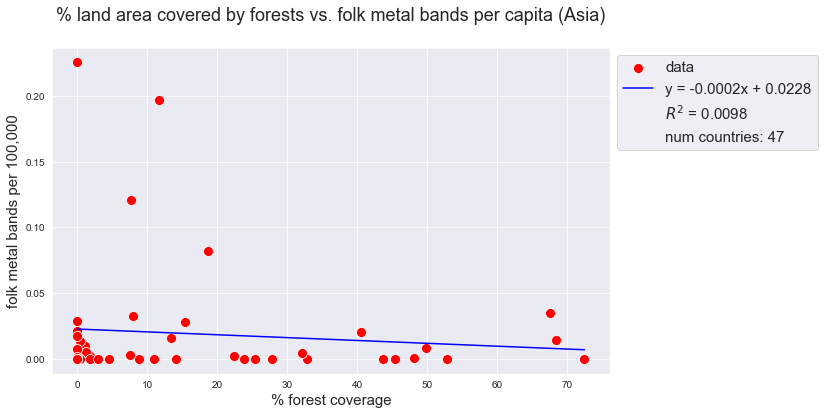

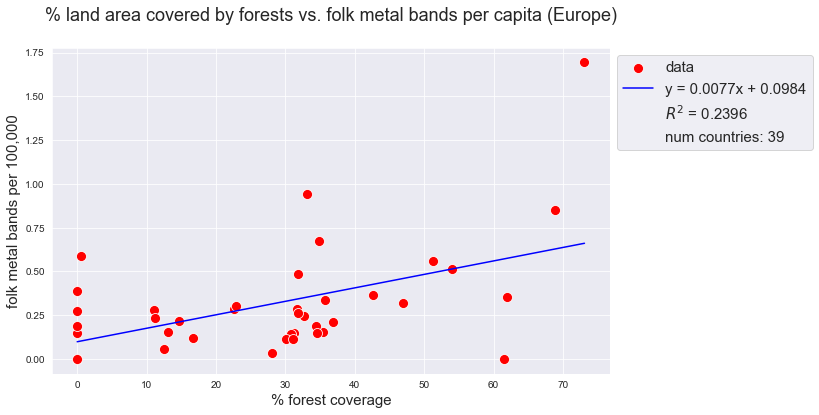

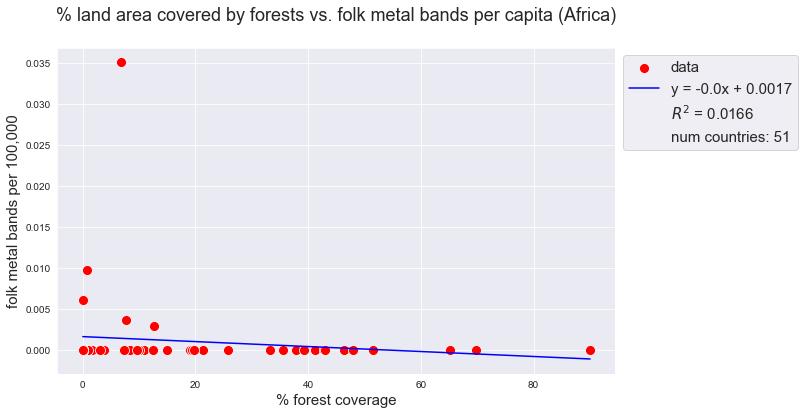

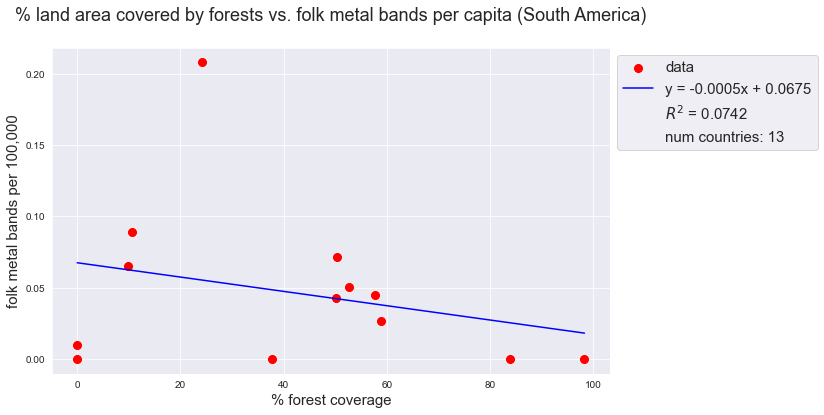

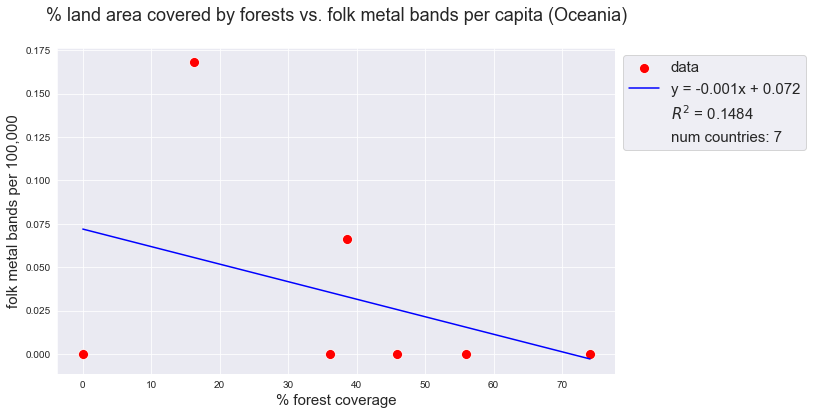

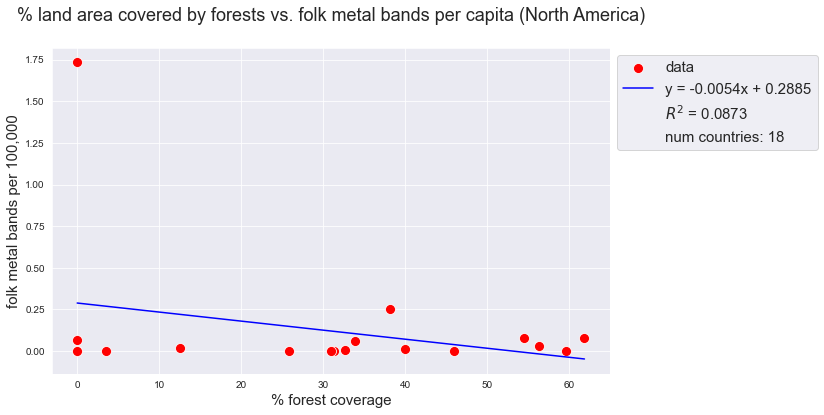

no folk metal bands in Seven seas (open ocean)
no folk metal bands in Antarctica


In [31]:
R_square = []
num_countries = []
continents = []

for continent in band_data['continent'].unique(): 
    try: 
        _, _, r_square, count = calc_regression(band_data[band_data['continent'] == continent], 
                    title=f"% land area covered by forests vs. folk metal bands per capita ({continent})\n");
        
        R_square = np.append(R_square, r_square)
        num_countries = np.append(num_countries, count)
        continents = np.append(continents, continent)
    except: 
        print(f"no folk metal bands in {continent}")

If we use the $R^2$ value as the key metric to evaluate performance, we see the following results: 

In [32]:
results = pd.DataFrame({'num countries': num_countries, '$R^2$': R_square}, 
                       index=continents).sort_values(by='$R^2$', ascending=False)
results.head()

num countries   $R^2$
Europe                  39.0  0.2396
Oceania                  7.0  0.1484
North America           18.0  0.0873
South America           13.0  0.0742
Africa                  51.0  0.0166

Clearly, Europe has the strongest correlation between the number of metal bands per capita and the % area covered by forests, with an $R^2$ 60% higher than that of the runner-up. 